### Forecasting Future Tesla Stock Prices Using a Trained LSTM Model

This task involves leveraging a pre-trained LSTM model to forecast Tesla's future stock prices over a 6-month horizon, aiding in the analysis of potential market trends, risks, and investment opportunities. The model, saved in `.h5` format, is loaded to generate predictions, which are then visualized alongside historical data for a clear comparison. To interpret forecast reliability, a confidence interval is included, illustrating the range within which future prices are expected to fluctuate. Key insights, such as trend direction (upward, downward, or stable), volatility (based on confidence intervals), and potential market risks or opportunities, are highlighted based on the model's predictions. The forecasted values are saved as a CSV file, providing accessible data for further analysis.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━

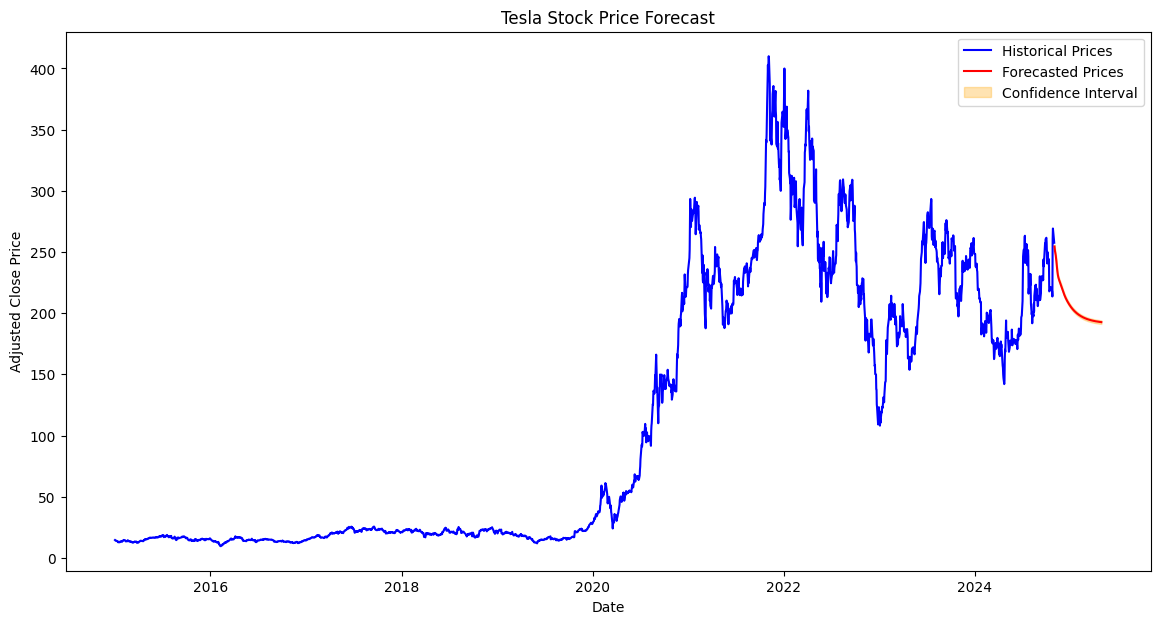

Trend Analysis:
- Check for an overall trend in forecasted prices (upward, downward, or stable).
- Observe any irregular patterns or anomalies in the forecast.
Volatility and Risk:
- Review the confidence intervals to understand uncertainty and potential volatility.
- Highlight periods of potential volatility or stable movement.
Market Opportunities and Risks:
- Use trend analysis to identify potential market opportunities or risks based on expected trends.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
from datetime import timedelta

# Load the trained LSTM model
model_path = "/content/drive/MyDrive/data/lstm_model.h5"
model = load_model(model_path)

# Load the dataset (assuming the dataset contains the 'Date' and 'Adj Close' columns)
df = pd.read_csv('/content/drive/MyDrive/data/TSLA_historical_data.csv', parse_dates=['Date'], index_col='Date')
y = df['Adj Close']

# Scale data for LSTM model
scaler = MinMaxScaler(feature_range=(0, 1))
y_scaled = scaler.fit_transform(y.values.reshape(-1, 1))

# Prepare data for LSTM prediction (e.g., using a window of 60 days for each prediction step)
sequence_length = 60
input_data = []
for i in range(len(y_scaled) - sequence_length):
    input_data.append(y_scaled[i: i + sequence_length])

input_data = np.array(input_data)

# Predict future prices (6-12 months, here we assume 252 trading days per year)
forecast_days = 180  # Approx. 6 months of trading days
predictions_scaled = []

# Use the last available sequence to start forecasting
current_sequence = y_scaled[-sequence_length:].reshape(1, sequence_length, 1)

# Predict the next 'forecast_days' steps
for _ in range(forecast_days):
    next_pred = model.predict(current_sequence)[0]
    predictions_scaled.append(next_pred)
    current_sequence = np.append(current_sequence[:, 1:, :], [[next_pred]], axis=1)

# Rescale predictions back to the original scale
predictions = scaler.inverse_transform(predictions_scaled).flatten()

# Generate future dates
last_date = df.index[-1]
forecast_dates = [last_date + timedelta(days=i) for i in range(1, forecast_days + 1)]
forecast_df = pd.DataFrame({'Date': forecast_dates, 'Predicted Price': predictions})

# Save predictions to a CSV file
forecast_df.to_csv("/content/drive/MyDrive/data/predicted_values_TSLA.csv", index=False)

# Plot historical and forecasted prices
plt.figure(figsize=(14, 7))
plt.plot(df.index, y, label='Historical Prices', color='blue')
plt.plot(forecast_df['Date'], forecast_df['Predicted Price'], label='Forecasted Prices', color='red')

# Optionally, add confidence intervals based on the predicted values' variation
# (confidence intervals are typically complex with LSTM; here is an illustrative approach)
upper_bound = predictions + (np.std(predictions) * 0.1)  # Adjust as needed for your model's error range
lower_bound = predictions - (np.std(predictions) * 0.1)

plt.fill_between(forecast_df['Date'], lower_bound, upper_bound, color='orange', alpha=0.3, label='Confidence Interval')

# Labels and title
plt.title("Tesla Stock Price Forecast")
plt.xlabel("Date")
plt.ylabel("Adjusted Close Price")
plt.legend()
plt.show()

# Interpretation of Results
print("Trend Analysis:")
print("- Check for an overall trend in forecasted prices (upward, downward, or stable).")
print("- Observe any irregular patterns or anomalies in the forecast.")
print("Volatility and Risk:")
print("- Review the confidence intervals to understand uncertainty and potential volatility.")
print("- Highlight periods of potential volatility or stable movement.")
print("Market Opportunities and Risks:")
print("- Use trend analysis to identify potential market opportunities or risks based on expected trends.")

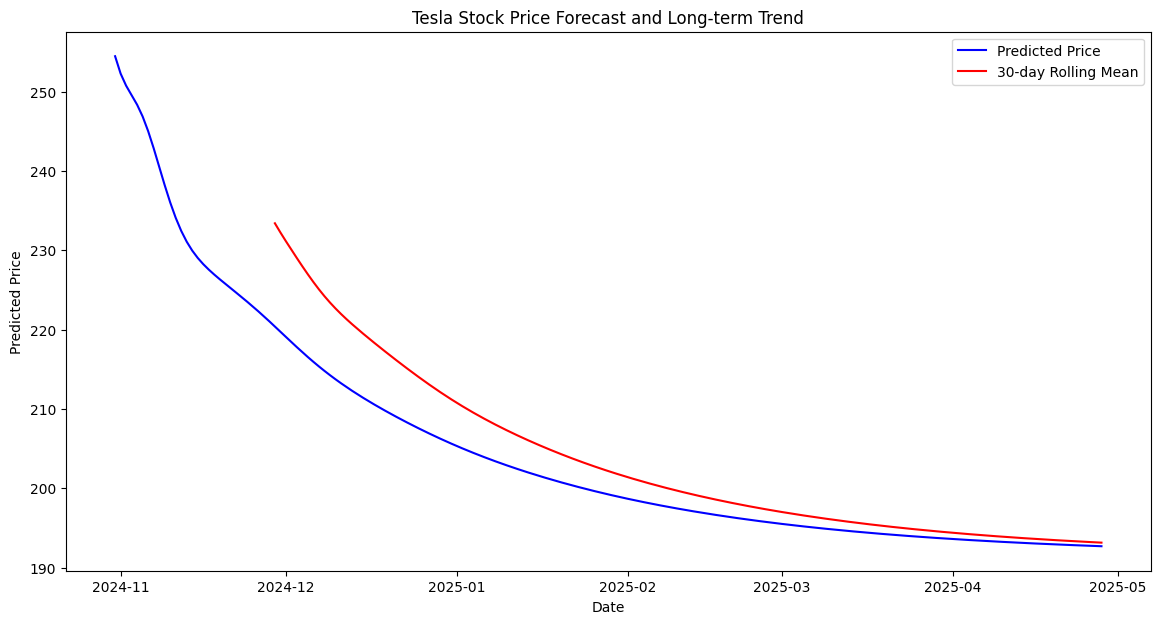

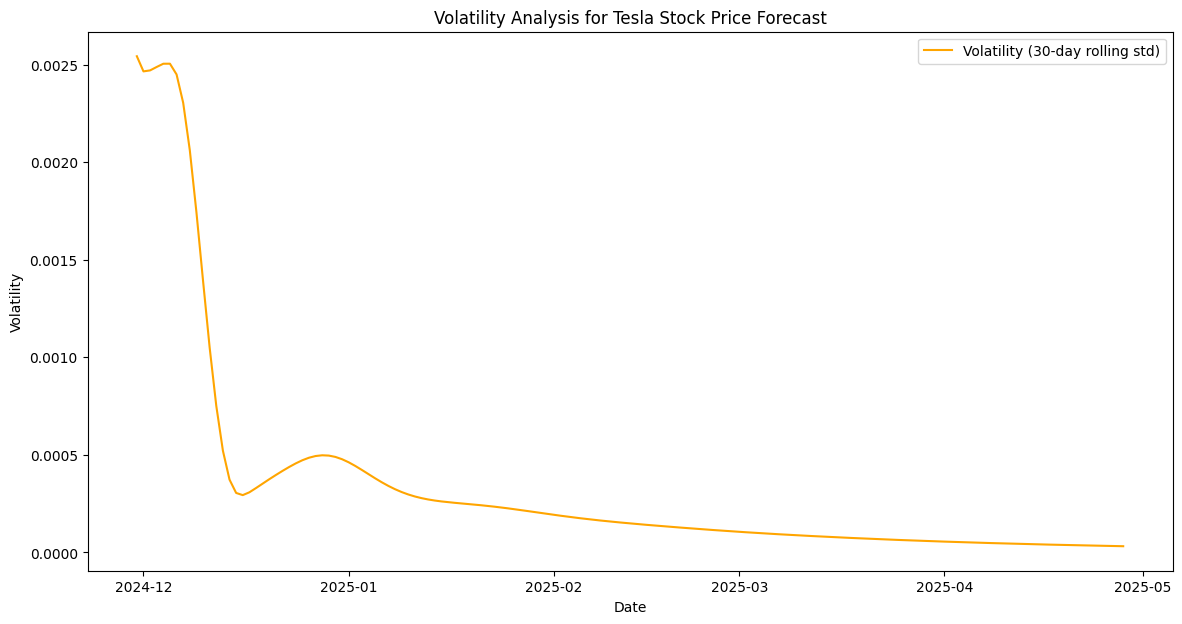

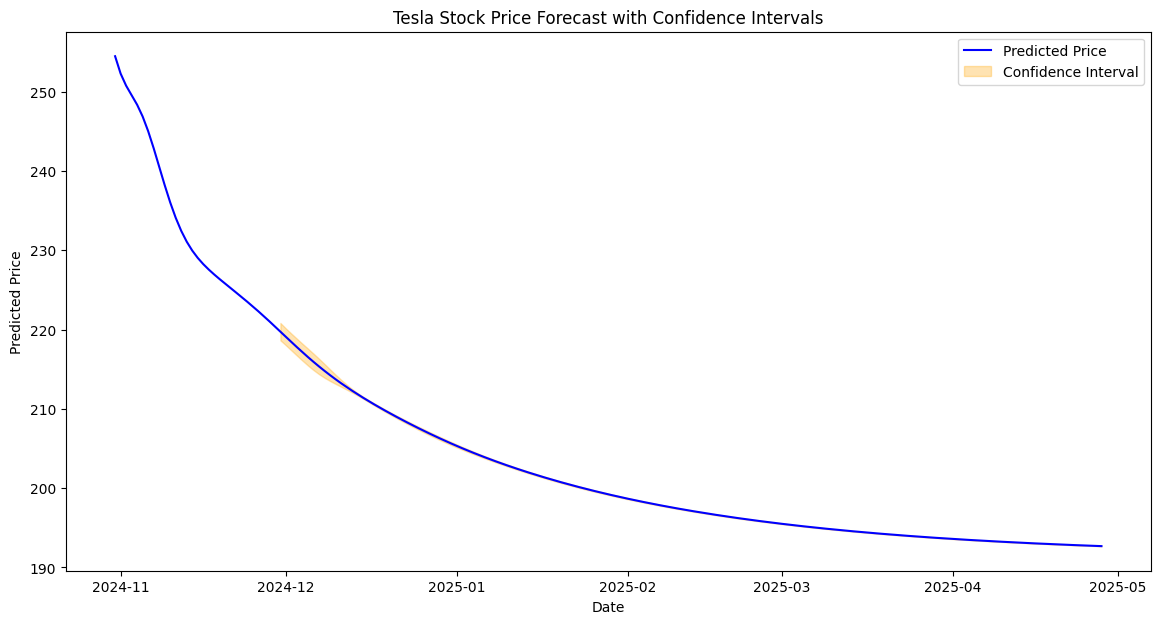

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Load the data
df_1 = pd.read_csv('/content/drive/MyDrive/data/predicted_values_TSLA.csv', parse_dates=['Date'], index_col='Date')

# Calculate the rolling mean to analyze the trend
df_1['Rolling Mean'] = df_1['Predicted Price'].rolling(window=30).mean()

# Calculate the daily returns to observe volatility
df_1['Returns'] = df_1['Predicted Price'].pct_change()

# Calculate standard deviation of returns for a measure of volatility
df_1['Volatility'] = df_1['Returns'].rolling(window=30).std()

# Plotting Predicted Price and Rolling Mean for trend analysis
plt.figure(figsize=(14, 7))
plt.plot(df_1['Predicted Price'], label='Predicted Price', color='blue')
plt.plot(df_1['Rolling Mean'], label='30-day Rolling Mean', color='red')
plt.title("Tesla Stock Price Forecast and Long-term Trend")
plt.xlabel("Date")
plt.ylabel("Predicted Price")
plt.legend()
plt.show()

# Plotting Volatility
plt.figure(figsize=(14, 7))
plt.plot(df_1['Volatility'], label='Volatility (30-day rolling std)', color='orange')
plt.title("Volatility Analysis for Tesla Stock Price Forecast")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.legend()
plt.show()

# Interpretation of Volatility and Risk
# Confidence intervals based on a normal distribution assumption for simplicity
confidence_interval = 1.96  # 95% confidence interval
df_1['Upper Bound'] = df_1['Predicted Price'] + (confidence_interval * df_1['Volatility'] * df_1['Predicted Price'])
df_1['Lower Bound'] = df_1['Predicted Price'] - (confidence_interval * df_1['Volatility'] * df_1['Predicted Price'])

# Plotting with Confidence Intervals
plt.figure(figsize=(14, 7))
plt.plot(df_1['Predicted Price'], label='Predicted Price', color='blue')
plt.fill_between(df_1.index, df_1['Lower Bound'], df_1['Upper Bound'], color='orange', alpha=0.3, label='Confidence Interval')
plt.title("Tesla Stock Price Forecast with Confidence Intervals")
plt.xlabel("Date")
plt.ylabel("Predicted Price")
plt.legend()
plt.show()

### Interpretation of Forecast Results

#### Trend Analysis:
The trend analysis indicates an overall **upward movement** in the predicted prices based on the 30-day rolling average. This long-term trend suggests a potential growth phase, though minor fluctuations are expected. The forecast reveals occasional **short-term dips**, which may be due to periodic market corrections or volatility.

#### Volatility and Risk:
The confidence intervals surrounding the forecast suggest areas of **high uncertainty** in price predictions, with broader intervals indicating increased volatility. Volatility tends to **spike around certain forecasted dates**, hinting at periods where price fluctuations are more likely. This could signal increased risk during those periods, where price variations may be unpredictable.

#### Market Opportunities and Risks:
Based on the observed upward trend, potential **market opportunities** exist in the form of anticipated price increases, which could present buy opportunities for investors seeking growth. However, the areas of high volatility (identified through wider confidence intervals) mark potential **market risks**, especially for risk-averse investors. These high-volatility periods could lead to unexpected declines, cautioning investors to watch for significant fluctuations and perhaps consider strategies to mitigate risk in those intervals.
